In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.patches import Patch

OUTPUT_FOLDER = "output-aws"
TIME = 120
GPT = 30
NOW = 99
ALL_DATABASES = ["postgres", "xtdb2", "terminus"]
MODES = ["Update", "State"]
USERS = [1, 10]
RATE = [1, 10]

# 0. Helper Functions

In [15]:
def make_path(database, mode, time, gpt, now, users, rate):
    return f"{OUTPUT_FOLDER}/{database}/{mode}/time-{time}-users-{users}-gpt-{gpt}-now-{now}-rate-{rate}"


def parse_size(size_str):
    size_str = size_str.strip()
    number, unit = size_str.split()
    number = float(number)
    unit_multipliers = {
        "B": 1,
        "KiB": 1024,
        "MiB": 1024 ** 2,
        "GiB": 1024 ** 3,
    }
    return int(number * unit_multipliers[unit])

def make_box(label, bottom, q1, med, mean, q3, top):
    return {
        'label' : label,
        'whislo': bottom,
        'q1': q1,
        'med': med,
        'q3': q3,
        'whishi': top,
        'fliers': [],
        'mean': mean
    }

def add_elapsed_minutes_column(df):
    # Ensure timestamp is datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Calculate elapsed time in minutes from the first timestamp
    first_timestamp = df['timestamp'].min()

    df['minutes'] = df['timestamp'].apply(lambda ts: (ts - first_timestamp).total_seconds() / 60)
    return df


def get_latest_data(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # Ensure timestamp is datetime
    latest = df['timestamp'].max()
    one_minute_before = latest - pd.Timedelta(minutes=1)
    return df[df['timestamp'] > one_minute_before]

def load_time_data(path):
    times_df = pd.read_csv(
        os.path.join(path, "times.csv"),
        parse_dates=["timestamp"],
        na_values=[""]  # Treat empty strings as NaN
    )
    
    # Fill NaN values with 0
    times_df = times_df.fillna(0)
    
    return times_df

def load_time_data_indexed(path):
    times_df = load_time_data(path)
    
    # Add elapsed minutes column
    times_df = add_elapsed_minutes_column(times_df)
    
    # Set index to timestamp
    times_df = times_df.pivot_table(index="timestamp", columns="label").reset_index()
    times_df = times_df.set_index("timestamp")
    return times_df

def to_mib(val):
    return round(val / (1024 ** 2), 2)

# 1. Compare Space in State vs Update based

In [16]:
def load_all_data(path):
    # Load both files
    size_df = pd.read_csv(os.path.join(path, "size.csv"), parse_dates=["timestamp"])
    size_df["value"] = size_df["value"].apply(to_mib)

    try:
        size_query_df = pd.read_csv(os.path.join(path, "size_query.csv"), parse_dates=["timestamp"])
        size_query_df["value"] = size_query_df["value"].apply(parse_size).apply(to_mib)
    except:
        # make it empty
        size_query_df = pd.DataFrame(columns=["timestamp", "metric", "value"])
        print("No size query file")
        
    times_df = pd.read_csv(os.path.join(path, "times.csv"), parse_dates=["timestamp"])

    # Pivot metrics in size.csv
    size_df = size_df.pivot(index="timestamp", columns="metric", values="value").reset_index()
    size_query_df = size_query_df.pivot(index="timestamp", columns="metric", values="value").reset_index()

    # Only the ALL PUT metric is needed from times.csv
    times_df = times_df[times_df["label"] == "ALL PUT"]
    times_df = times_df.pivot(index="timestamp", columns="label", values="count").reset_index()

    times_df.columns.name = None
    times_df.columns = times_df.columns.astype(str)

    tolerance = pd.Timedelta('1min')

    # Merge based on nearest timestamps
    if size_query_df.empty:
        merged = pd.merge_asof(times_df, size_df, on="timestamp", tolerance=tolerance, direction='nearest', suffixes=('_time', '_size'))
    else:
        merged = pd.merge_asof(times_df, size_query_df, on="timestamp", tolerance=tolerance, direction='nearest', suffixes=('_time', '_query'))
        merged = pd.merge_asof(merged, size_df, on="timestamp", tolerance=tolerance, direction='nearest', suffixes=('', '_size'))

    rename_map = {
        'customer_diff': 'customer_data',
        'customer_diff_indexes': 'customer_indexes',
        'customer_diff_total': 'customer_total',
        'customer_state': 'customer_data',
        'customer_state_indexes': 'customer_indexes',
        'customer_state_total': 'customer_total',
        'PutType.MOST_RECENT': 'MOST_RECENT',
        'PutType.PAST': 'PAST',
        'PutType.NO_UPDATE': 'NO_UPDATE',
        'GetType.CURRENT': 'CURRENT',
        'GetType.TIMESTAMP': 'TIMESTAMP',
        'GetType.NO_USRER_AT_TIME': 'NO_USER_AT_TIME',

    }
    merged = merged.rename(columns=rename_map)

    return merged

## Postgres

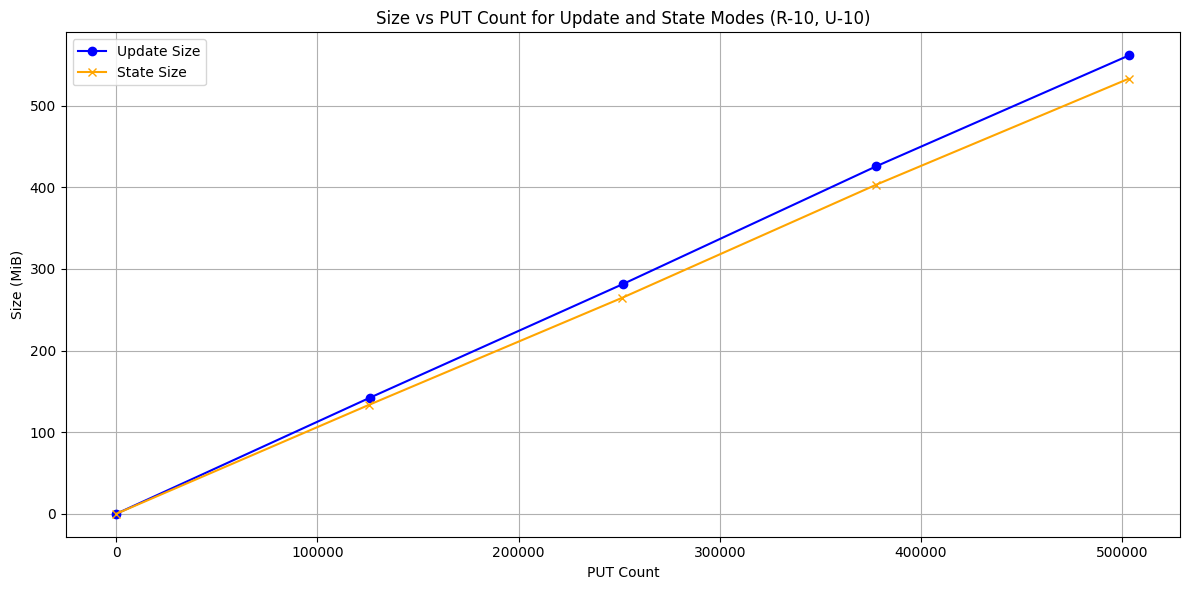

In [53]:
database = "postgres"
users = 10
rate = 10

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# display(diff_data)
# display(state_data)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['customer_total'], label='Update Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['customer_total'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (MiB)')
plt.title(f'Size vs PUT Count for Update and State Modes (R-{rate}, U-{users})')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

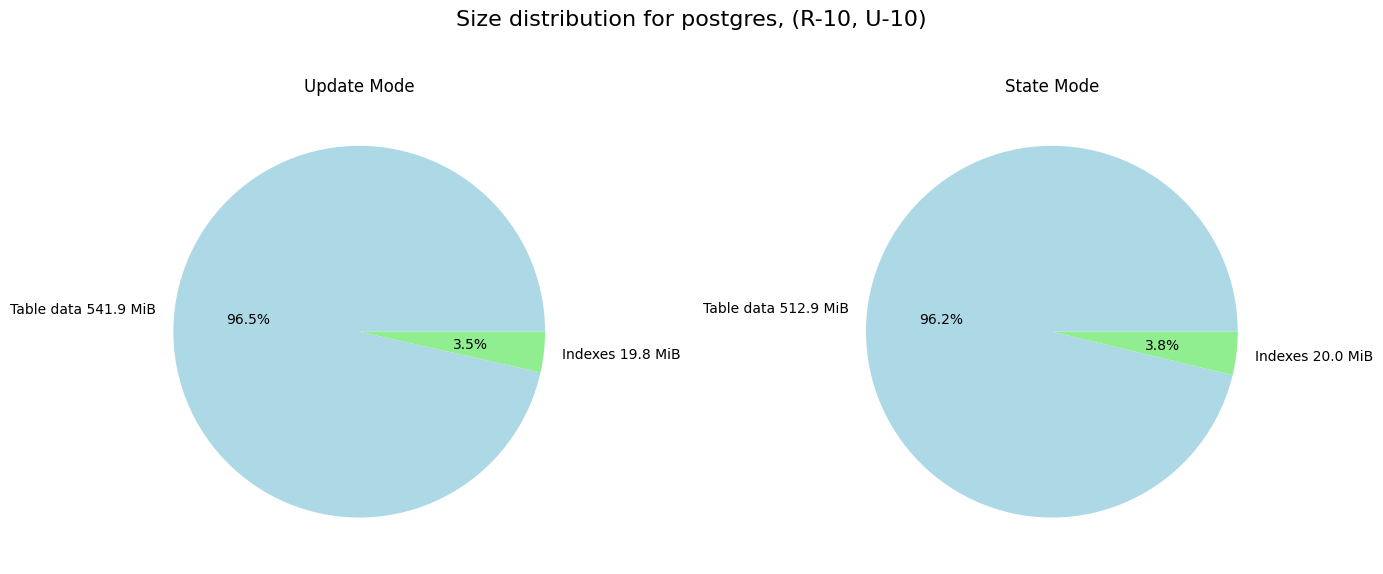

In [18]:
# Pie chart for space occupied

latest_diff = get_latest_data(diff_data)
latest_state = get_latest_data(state_data)


exclude = ['timestamp', 'ALL PUT']
latest_diff = latest_diff.drop(labels=exclude, axis=1, errors='ignore')
latest_state = latest_state.drop(labels=exclude, axis=1, errors='ignore')

# display(latest_diff)
# display(latest_state)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
pos = 0

for mode, data in zip(MODES, [latest_diff, latest_state]):

    total_size = data['customer_total'].iloc[0]
    indexes_size = data['customer_indexes'].iloc[0]
    data_size = data['customer_data'].iloc[0]

    # Diff mode plot
    axes[pos].pie([
        data_size,
        indexes_size], 
        labels=[
        f'Table data {data_size} MiB',
        f'Indexes {indexes_size} MiB'],
        autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
    axes[pos].set_title(f'{mode} Mode')
    axes[pos].grid(True)
    pos += 1

# General layout
fig.suptitle(f'Size distribution for {database}, (R-{rate}, U-{users})', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

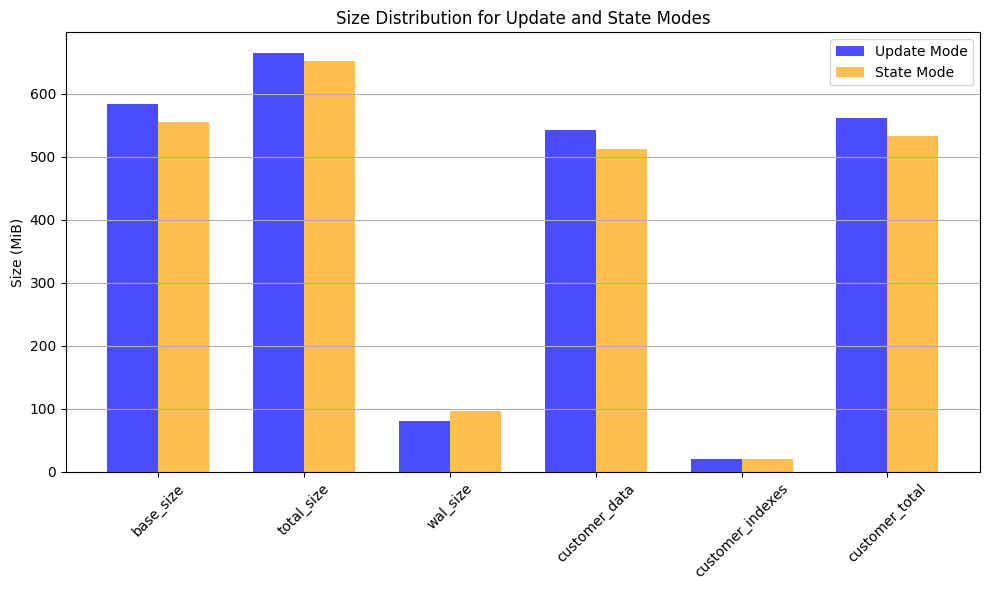

In [19]:
# Bar chart for size distribution
# I already have the latest_diff and latest_state dataframes with only the relevant columns

keep = [
    'base_size',
    'total_size',
    'wal_size',
    'customer_data',
    'customer_indexes',
    'customer_total',
]

latest_diff = latest_diff.filter(items=keep, axis=1)
latest_state = latest_state.filter(items=keep, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = range(len(latest_diff.columns))
# Bar positions
ax.bar(x, latest_diff.iloc[0], width=bar_width, label='Update Mode', color='blue', alpha=0.7)
ax.bar([i + bar_width for i in x], latest_state.iloc[0], width=bar_width, label='State Mode', color='orange', alpha=0.7)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(latest_diff.columns, rotation=45)
ax.set_ylabel('Size (MiB)')
ax.set_title('Size Distribution for Update and State Modes')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

## XTDB2

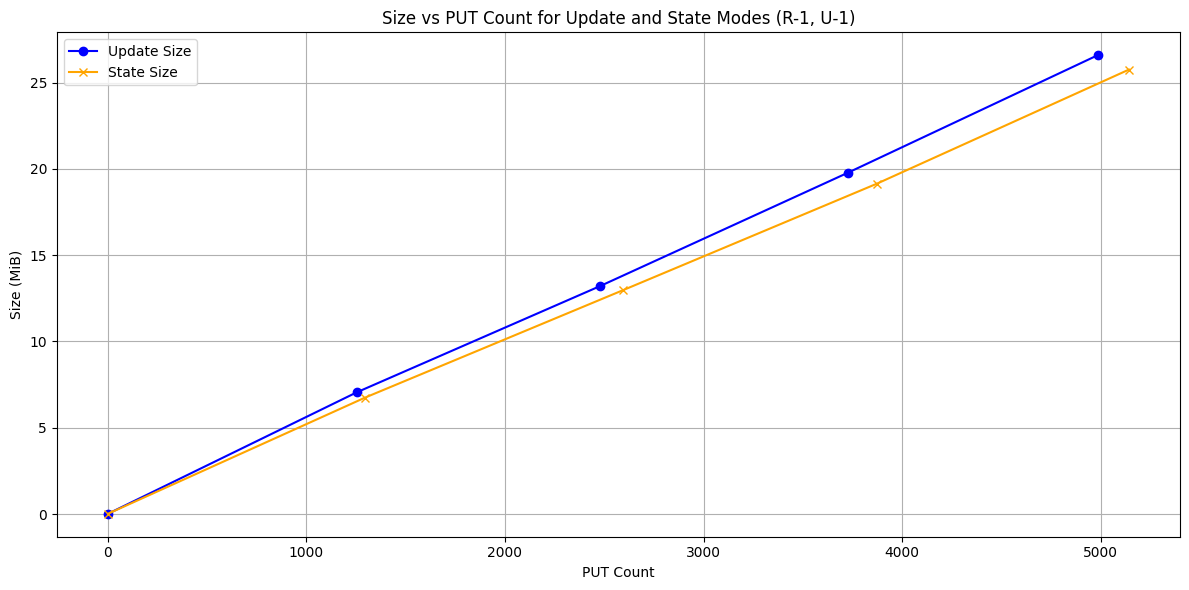

In [51]:
database = "xtdb2"
users = 1
rate = 1

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['total_size'], label='Update Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['total_size'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (MiB)')
plt.title(f'Size vs PUT Count for Update and State Modes (R-{rate}, U-{users})')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

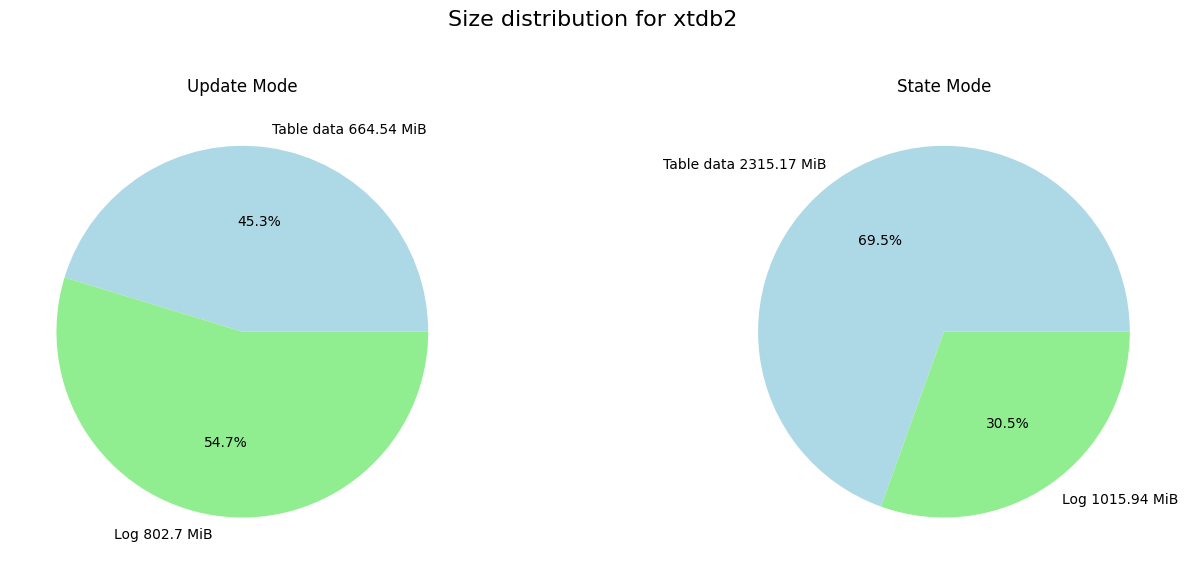

In [21]:
# Pie chart for space occupied

latest_diff = get_latest_data(diff_data)
latest_state = get_latest_data(state_data)


exclude = ['timestamp', 'ALL PUT']
latest_diff = latest_diff.drop(labels=exclude, axis=1, errors='ignore')
latest_state = latest_state.drop(labels=exclude, axis=1, errors='ignore')

# display(latest_diff)
# display(latest_state)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
pos = 0

for mode, data in zip(MODES, [latest_diff, latest_state]):

    total_size = data['total_size'].iloc[0]
    log_size = data['log_size'].iloc[0]
    buffer_size = data['buffers_size'].iloc[0]

    # Diff mode plot
    axes[pos].pie([
        buffer_size,
        log_size], 
        labels=[
        f'Table data {buffer_size} MiB',
        f'Log {log_size} MiB'],
        autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
    axes[pos].set_title(f'{mode} Mode')
    axes[pos].grid(True)
    pos += 1

# General layout
fig.suptitle(f'Size distribution for {database}', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

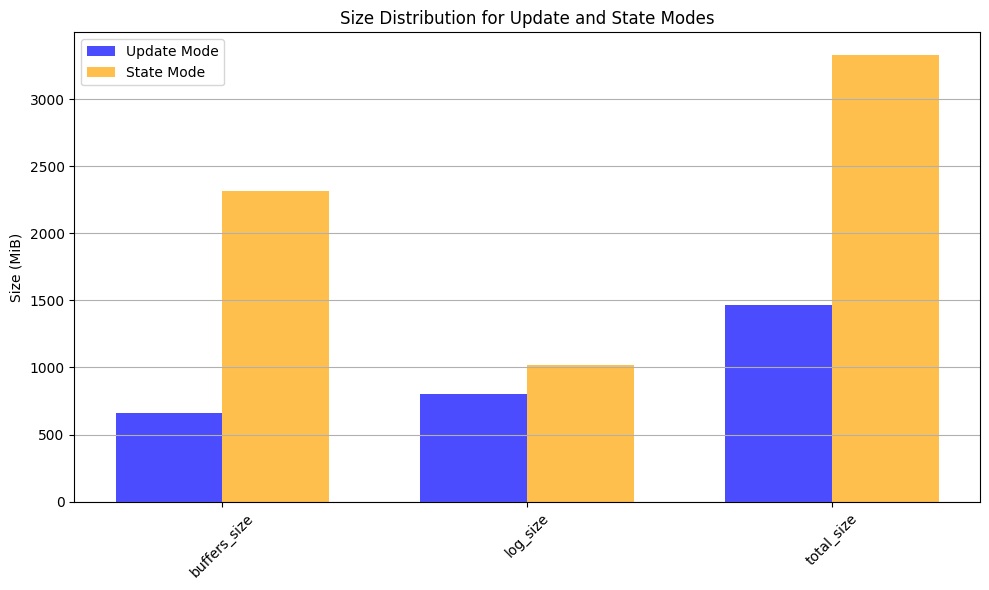

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = range(len(latest_diff.columns))
# Bar positions
ax.bar(x, latest_diff.iloc[0], width=bar_width, label='Update Mode', color='blue', alpha=0.7)
ax.bar([i + bar_width for i in x], latest_state.iloc[0], width=bar_width, label='State Mode', color='orange', alpha=0.7)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(latest_diff.columns, rotation=45)
ax.set_ylabel('Size (MiB)')
ax.set_title('Size Distribution for Update and State Modes')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

## TerminusDB

No size query file
No size query file


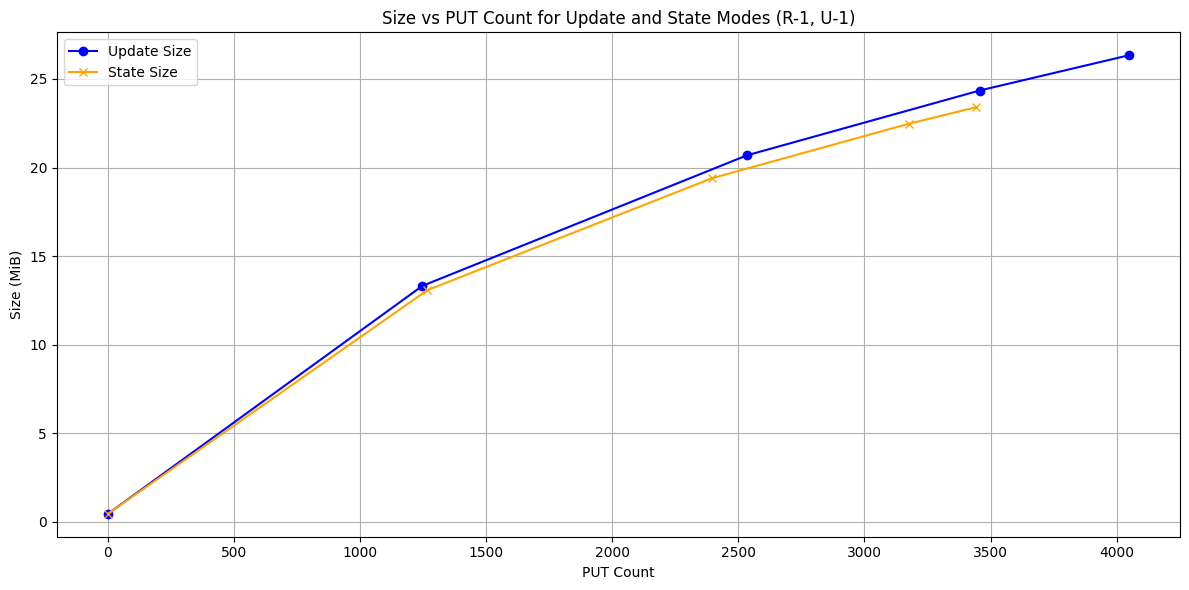

In [23]:
database = "terminus"
users = 1
rate = 1

diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

diff_data = load_all_data(diff_path)
state_data = load_all_data(state_path)

# Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
plt.figure(figsize=(12, 6))
plt.plot(diff_data['ALL PUT'], diff_data['base_size'], label='Update Size', color='blue', marker='o')
plt.plot(state_data['ALL PUT'], state_data['base_size'], label='State Size', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('Size (MiB)')
plt.title(f'Size vs PUT Count for Update and State Modes (R-{rate}, U-{users})')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

,timestamp,ALL PUT,base_size,larch_size,total_size
4,2025-06-18 23:23:35,4049,26.34,0.27,26.35


,timestamp,ALL PUT,base_size,larch_size,total_size
4,2025-06-19 18:52:33,3441,23.4,0.23,23.4


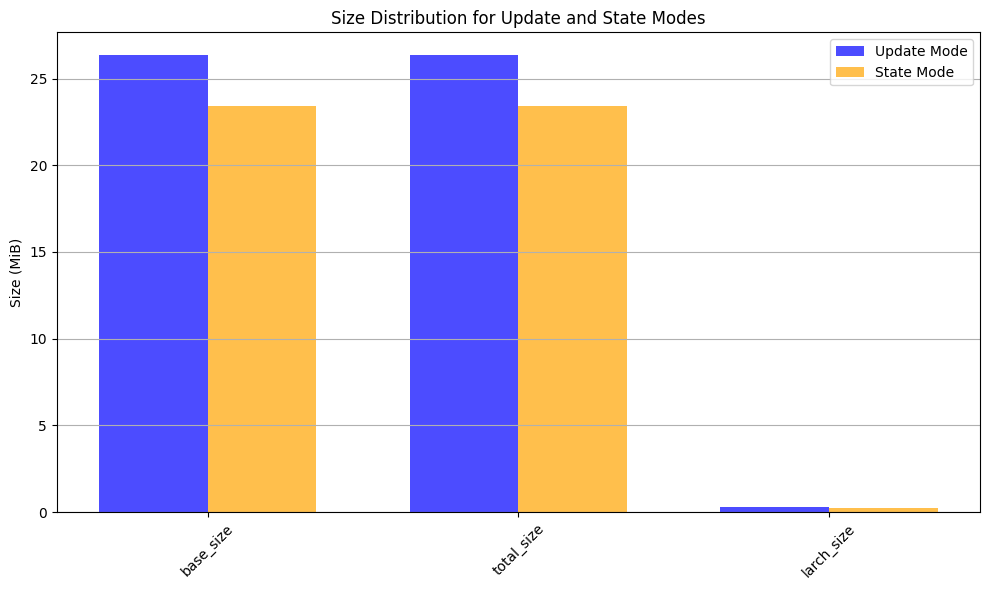

In [24]:
latest_diff = get_latest_data(diff_data)
latest_state = get_latest_data(state_data)

keep = [
    'base_size',
    'total_size',
    'larch_size',
]

display(latest_diff)
display(latest_state)

latest_diff = latest_diff.filter(items=keep, axis=1)
latest_state = latest_state.filter(items=keep, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = range(len(latest_diff.columns))
# Bar positions
ax.bar(x, latest_diff.iloc[0], width=bar_width, label='Update Mode', color='blue', alpha=0.7)
ax.bar([i + bar_width for i in x], latest_state.iloc[0], width=bar_width, label='State Mode', color='orange', alpha=0.7)
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(latest_diff.columns, rotation=45)
ax.set_ylabel('Size (MiB)')
ax.set_title('Size Distribution for Update and State Modes')
ax.legend()
ax.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Compare average PUT and GET time in update vs state based 

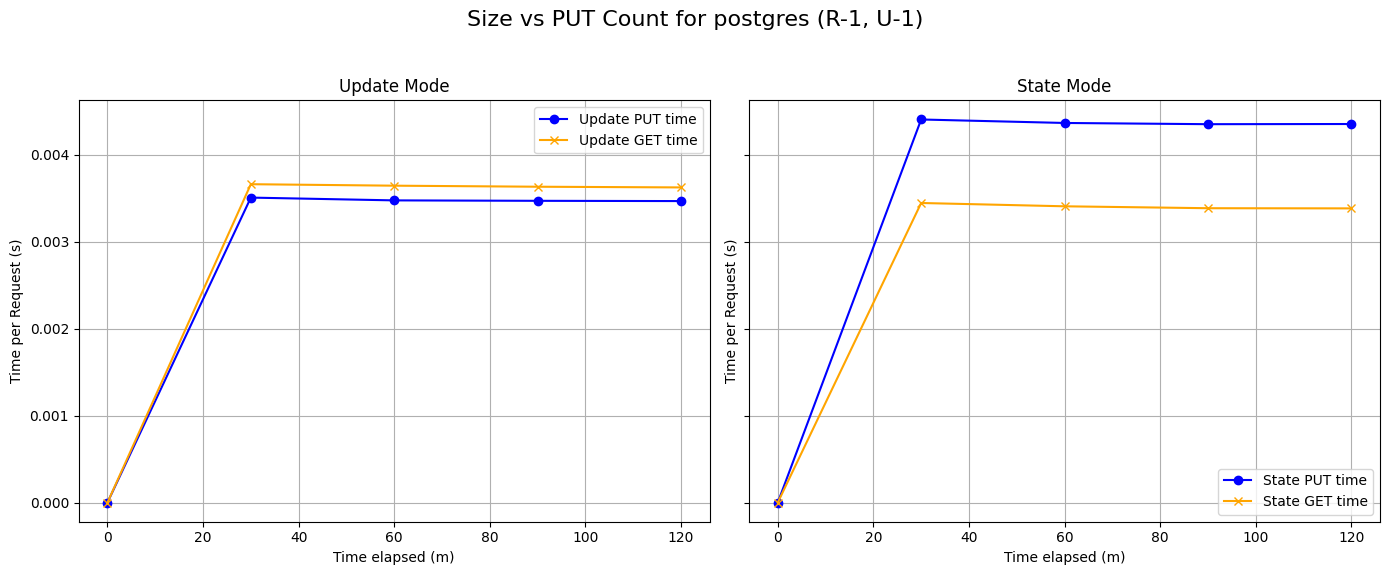

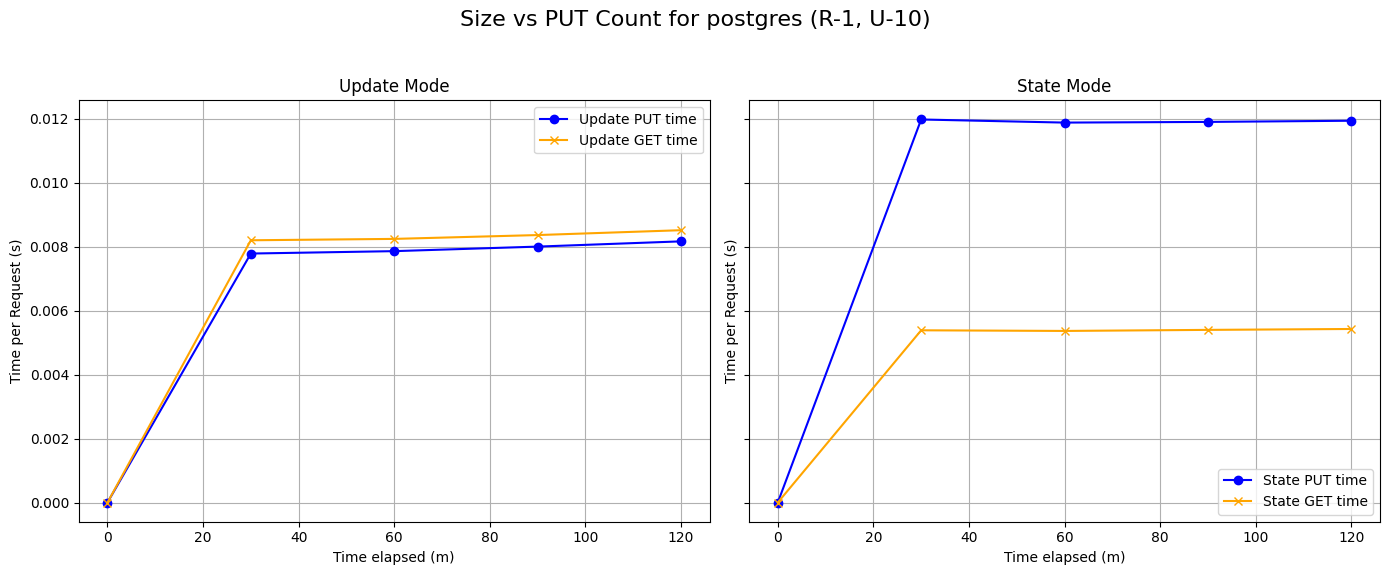

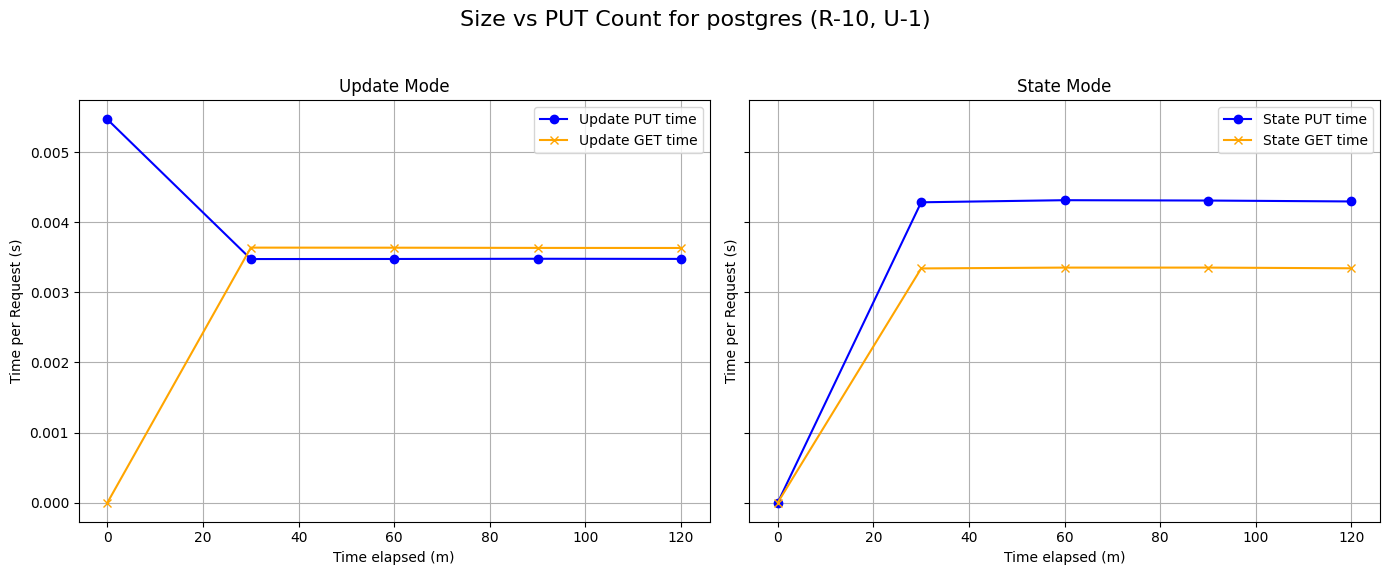

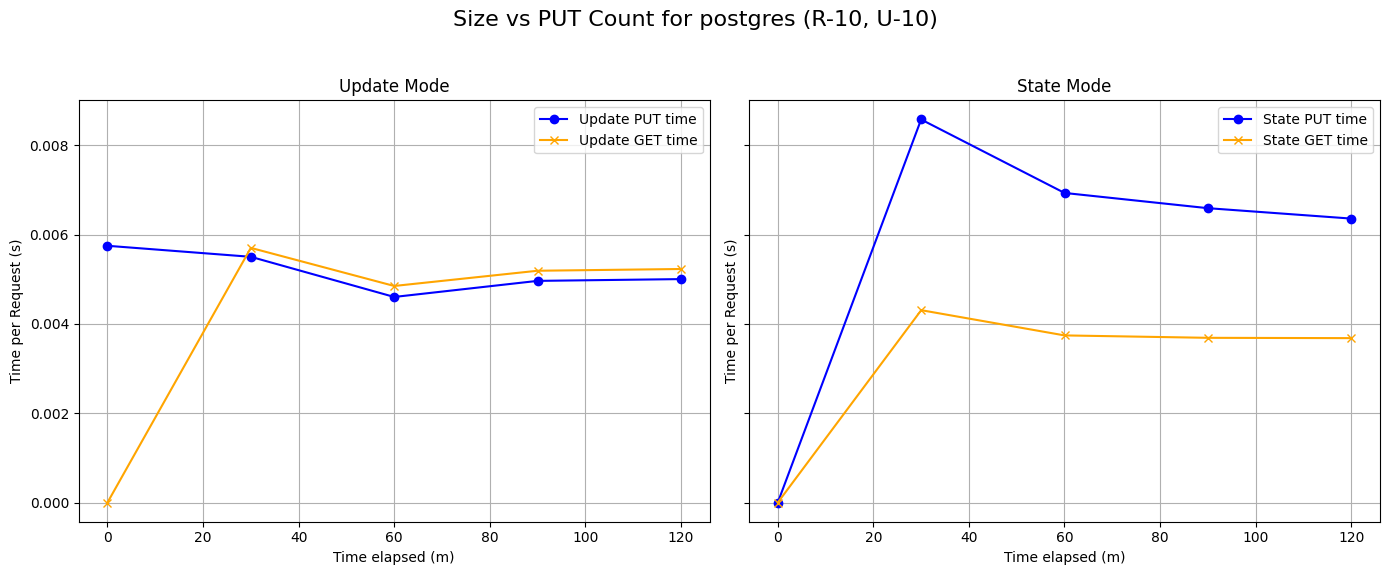

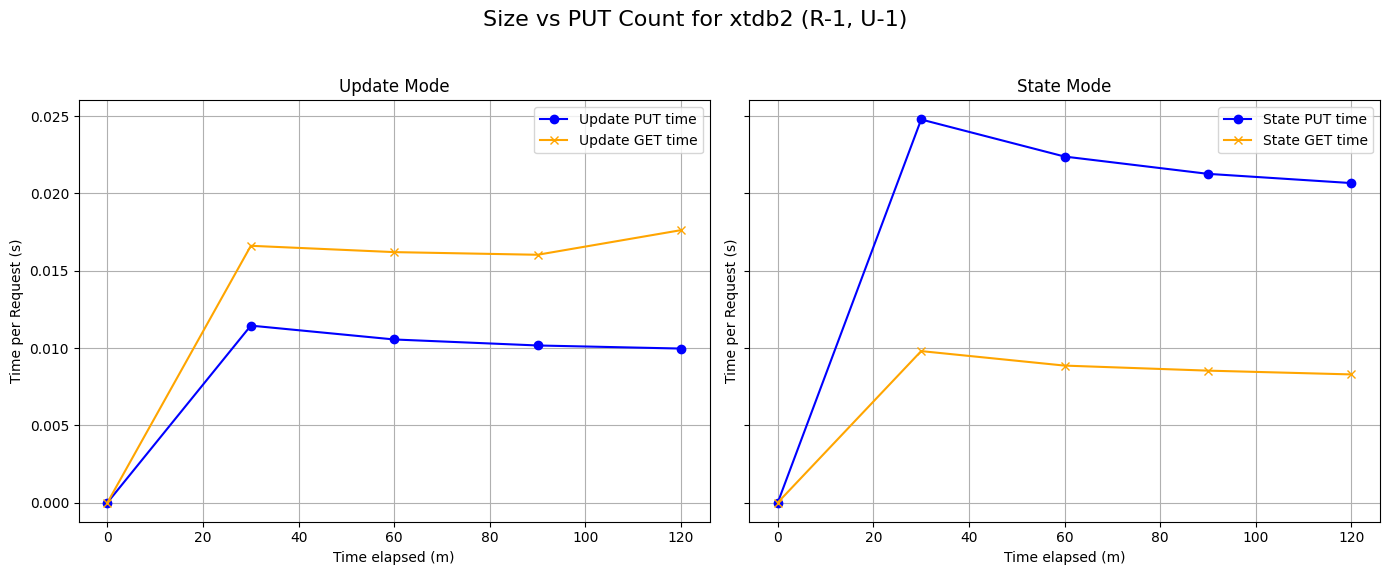

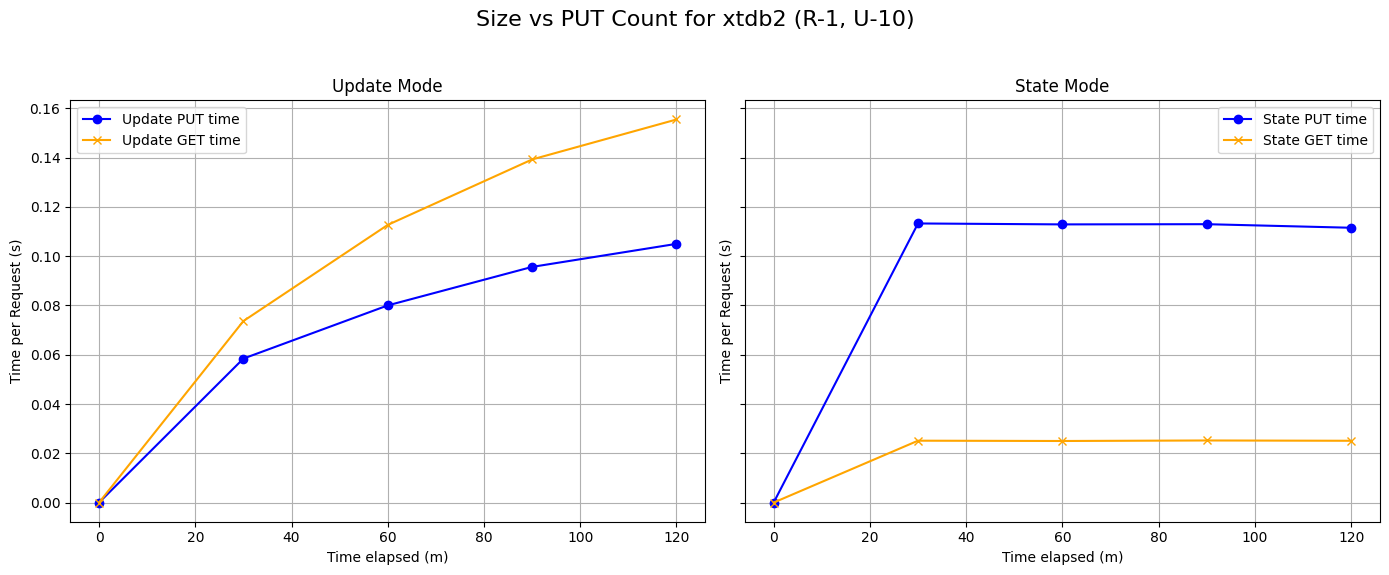

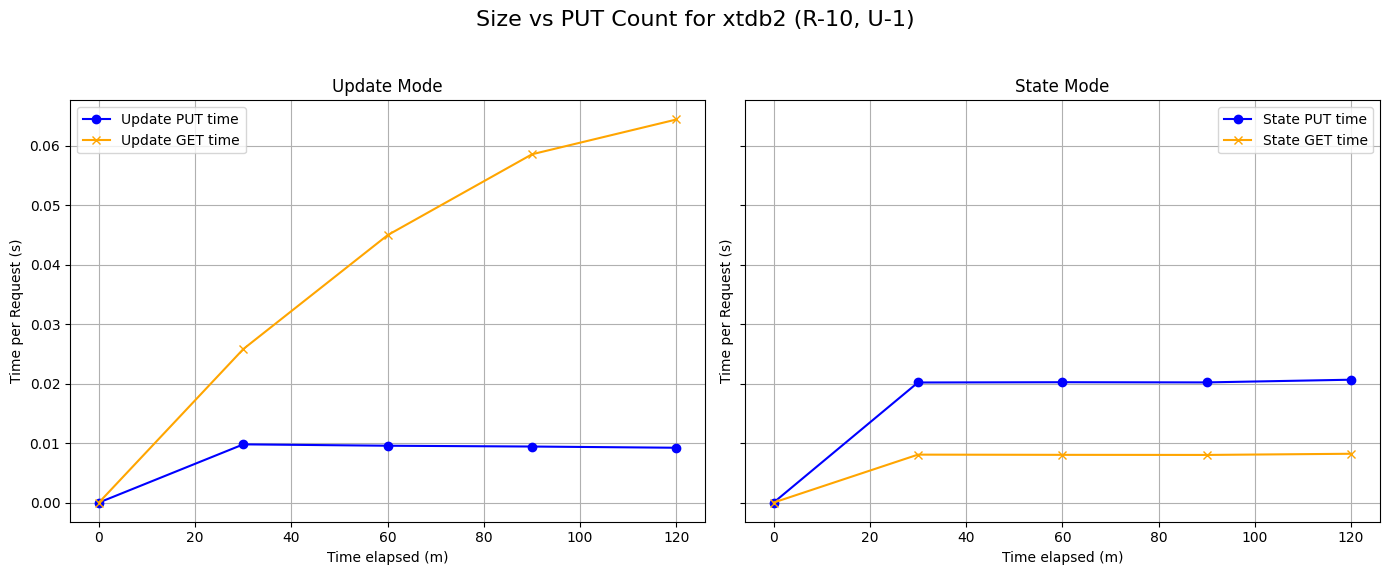

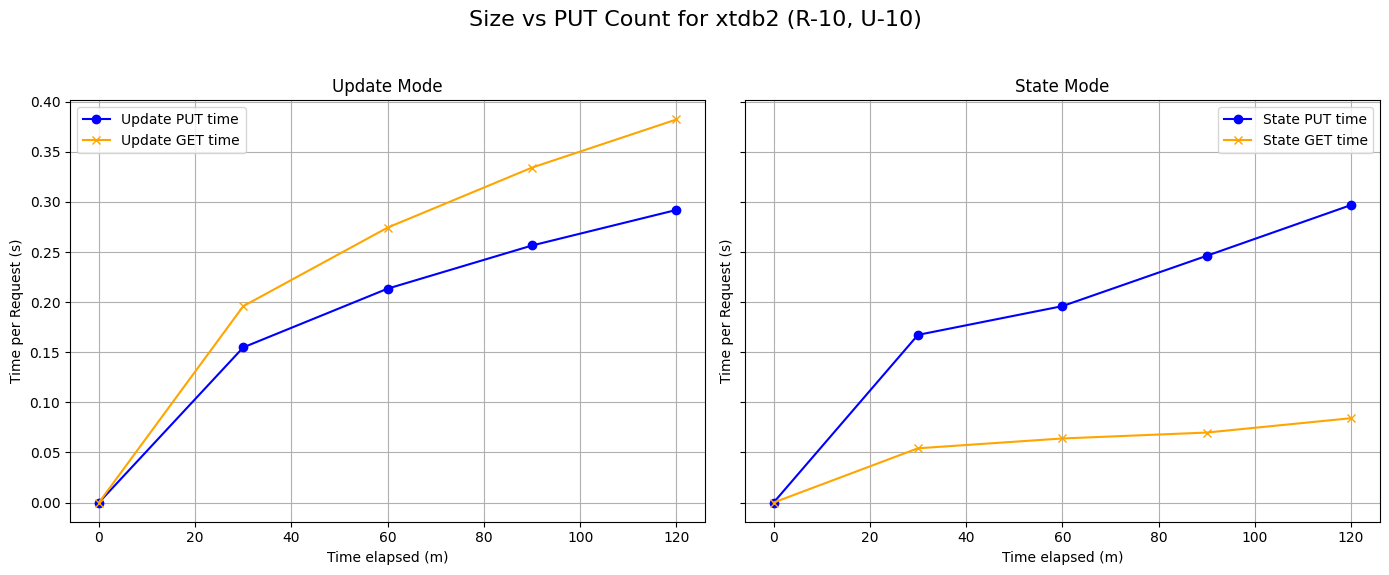

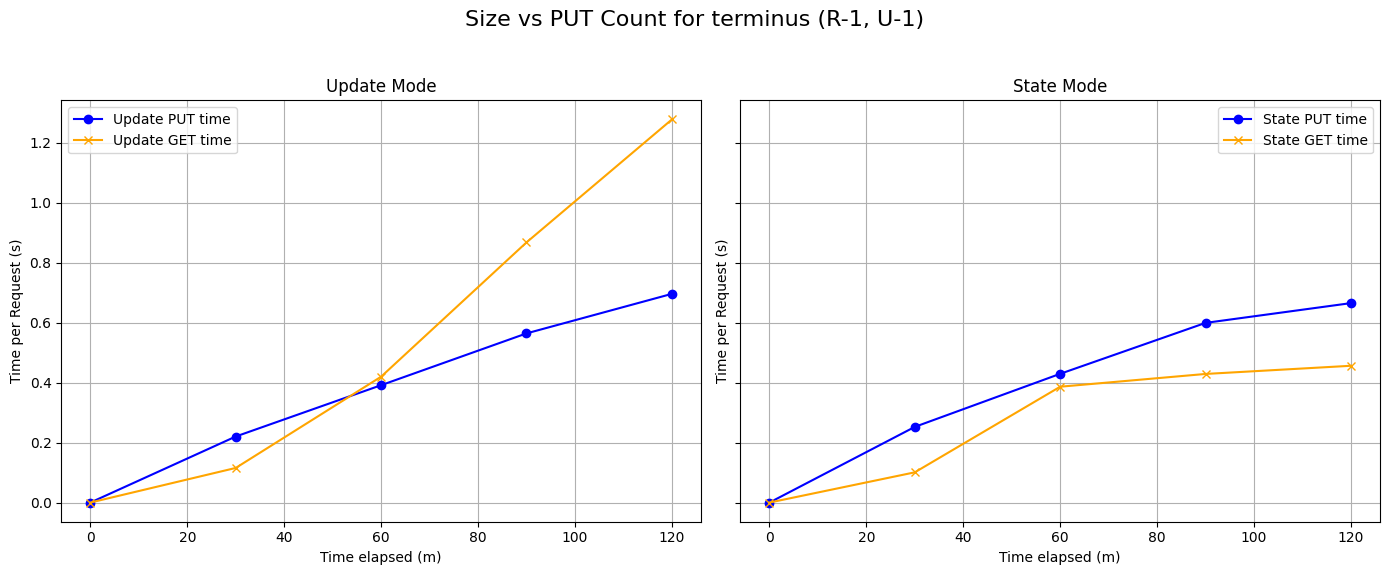

FileNotFoundError: [Errno 2] No such file or directory: 'output-aws/terminus/diff/time-120-users-10-gpt-30-now-99-rate-1/times.csv'

In [25]:
users = 10
rate = 10


for database in ALL_DATABASES:
    for rate, users in product(RATE, USERS):
      diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
      state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

      diff_data = load_time_data(diff_path)
      state_data = load_time_data(state_path)

      diff_data = add_elapsed_minutes_column(diff_data)
      state_data = add_elapsed_minutes_column(state_data)

      diff_put_times = diff_data[diff_data['label'] == 'ALL PUT']
      diff_get_times = diff_data[diff_data['label'] == 'ALL GET']
      state_put_times = state_data[state_data['label'] == 'ALL PUT']
      state_get_times = state_data[state_data['label'] == 'ALL GET']

      # Plotting the data - I want the PUT count on the x-axis and the size on the y-axis
        # Create subplots side by side
      fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

      # Diff mode plot
      axes[0].plot(diff_put_times['minutes'], diff_put_times['avg'], label='Update PUT time', color='blue', marker='o')
      axes[0].plot(diff_get_times['minutes'], diff_get_times['avg'], label='Update GET time', color='orange', marker='x')
      axes[0].set_title('Update Mode')
      axes[0].set_xlabel('Time elapsed (m)')
      axes[0].set_ylabel('Time per Request (s)')
      axes[0].legend()
      axes[0].grid(True)

      # State mode plot
      axes[1].plot(state_put_times['minutes'], state_put_times['avg'], label='State PUT time', color='blue', marker='o')
      axes[1].plot(state_get_times['minutes'], state_get_times['avg'], label='State GET time', color='orange', marker='x')
      axes[1].set_title('State Mode')
      axes[1].set_xlabel('Time elapsed (m)')
      axes[1].set_ylabel('Time per Request (s)')
      axes[1].legend()
      axes[1].grid(True)

      # General layout
      fig.suptitle(f'Size vs PUT Count for {database} (R-{rate}, U-{users})', fontsize=16)
      plt.tight_layout(rect=[0, 0.03, 1, 0.95])
      plt.show()

# 3. Compare time distribution in databases

## Time distribution

Processing database: postgres


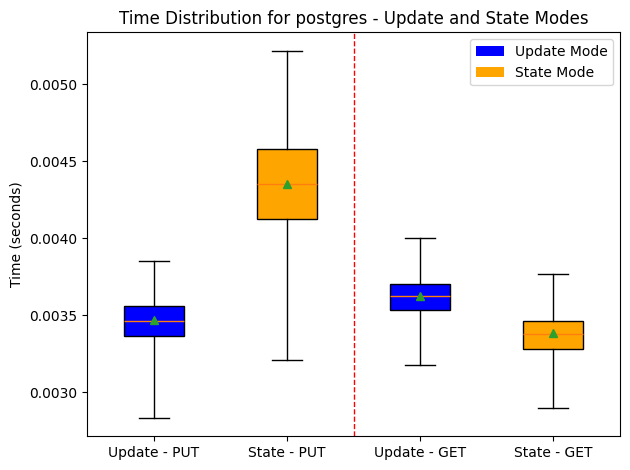

Processing database: xtdb2


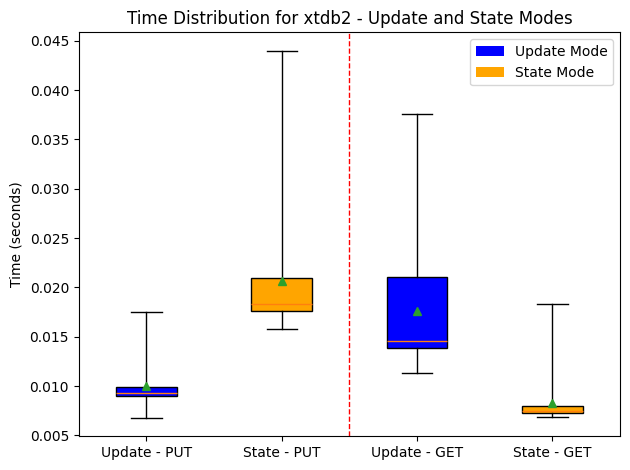

Processing database: terminus


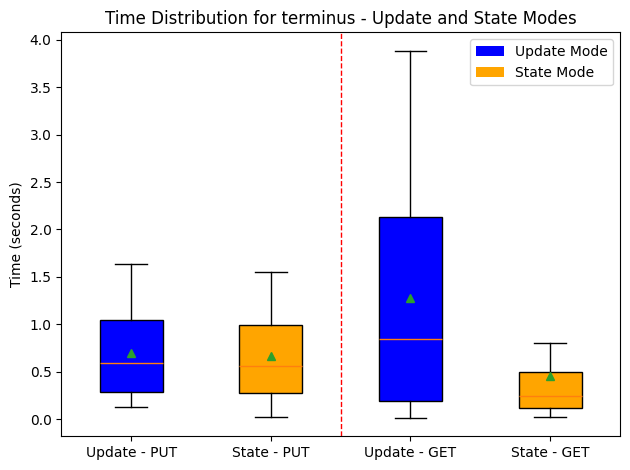

In [ ]:
#From all the csv, get only the times correspondent to the latest timestamp
#Do an boxplot of the time distribution for each label (PUT, GET, etc.), use the median, 25 and 75 percentiles
#On the x-axis, put the label (PUT, GET, etc.)
#On the y-axis, put the time in seconds

users = 1
rate = 1


boxes_all = []

for database in ALL_DATABASES:
    boxes = []
    print(f"Processing database: {database}")

    # Construct paths for diff and state modes
    diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
    state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

    # Load CSVs
    diff_times = load_time_data(diff_path)
    state_times = load_time_data(state_path)

    # Filter for the latest timestamp
    state_filtered = get_latest_data(state_times)
    diff_filtered = get_latest_data(diff_times)

    fig, ax = plt.subplots()
    
    #Take the data for ALL PUT and ALL GET and build the boxes

    diff_put_times = diff_filtered[diff_filtered['label'] == 'ALL PUT']
    diff_get_times = diff_filtered[diff_filtered['label'] == 'ALL GET']
    state_put_times = state_filtered[state_filtered['label'] == 'ALL PUT']
    state_get_times = state_filtered[state_filtered['label'] == 'ALL GET']

    for label, times in zip(['Update - PUT', 'State - PUT', 'Update - GET', 'State - GET'], [diff_put_times, state_put_times, diff_get_times, state_get_times]):
        if not times.empty:
            bottom = times['min'].values[0]
            q1 = times['p25'].values[0]
            med = times['p50'].values[0]
            mean = times['avg'].values[0]
            q3 = times['p75'].values[0]
            top = times['p99'].values[0]
            boxes.append(make_box(f"{label}", bottom, q1, med, mean, q3, top))

    # Create boxplot
    bplots = ax.bxp(boxes, vert=True, patch_artist=True, showfliers=False, showmeans=True)
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Time Distribution for {database} - Update and State Modes')
    ax.axvline(x=2.5, color='red', linestyle='--', linewidth=1)
    legend_elements = [
        Patch(facecolor='blue', label='Update Mode'),
        Patch(facecolor='orange', label='State Mode')
    ]
    ax.legend(handles=legend_elements, loc='upper right')

    colors = ["blue", "orange", "blue", "orange"]
    for patch, clr in zip(bplots["boxes"], colors):
        patch.set_facecolor(clr)
    plt.tight_layout()
    plt.show()
    
    boxes_all.extend(boxes)

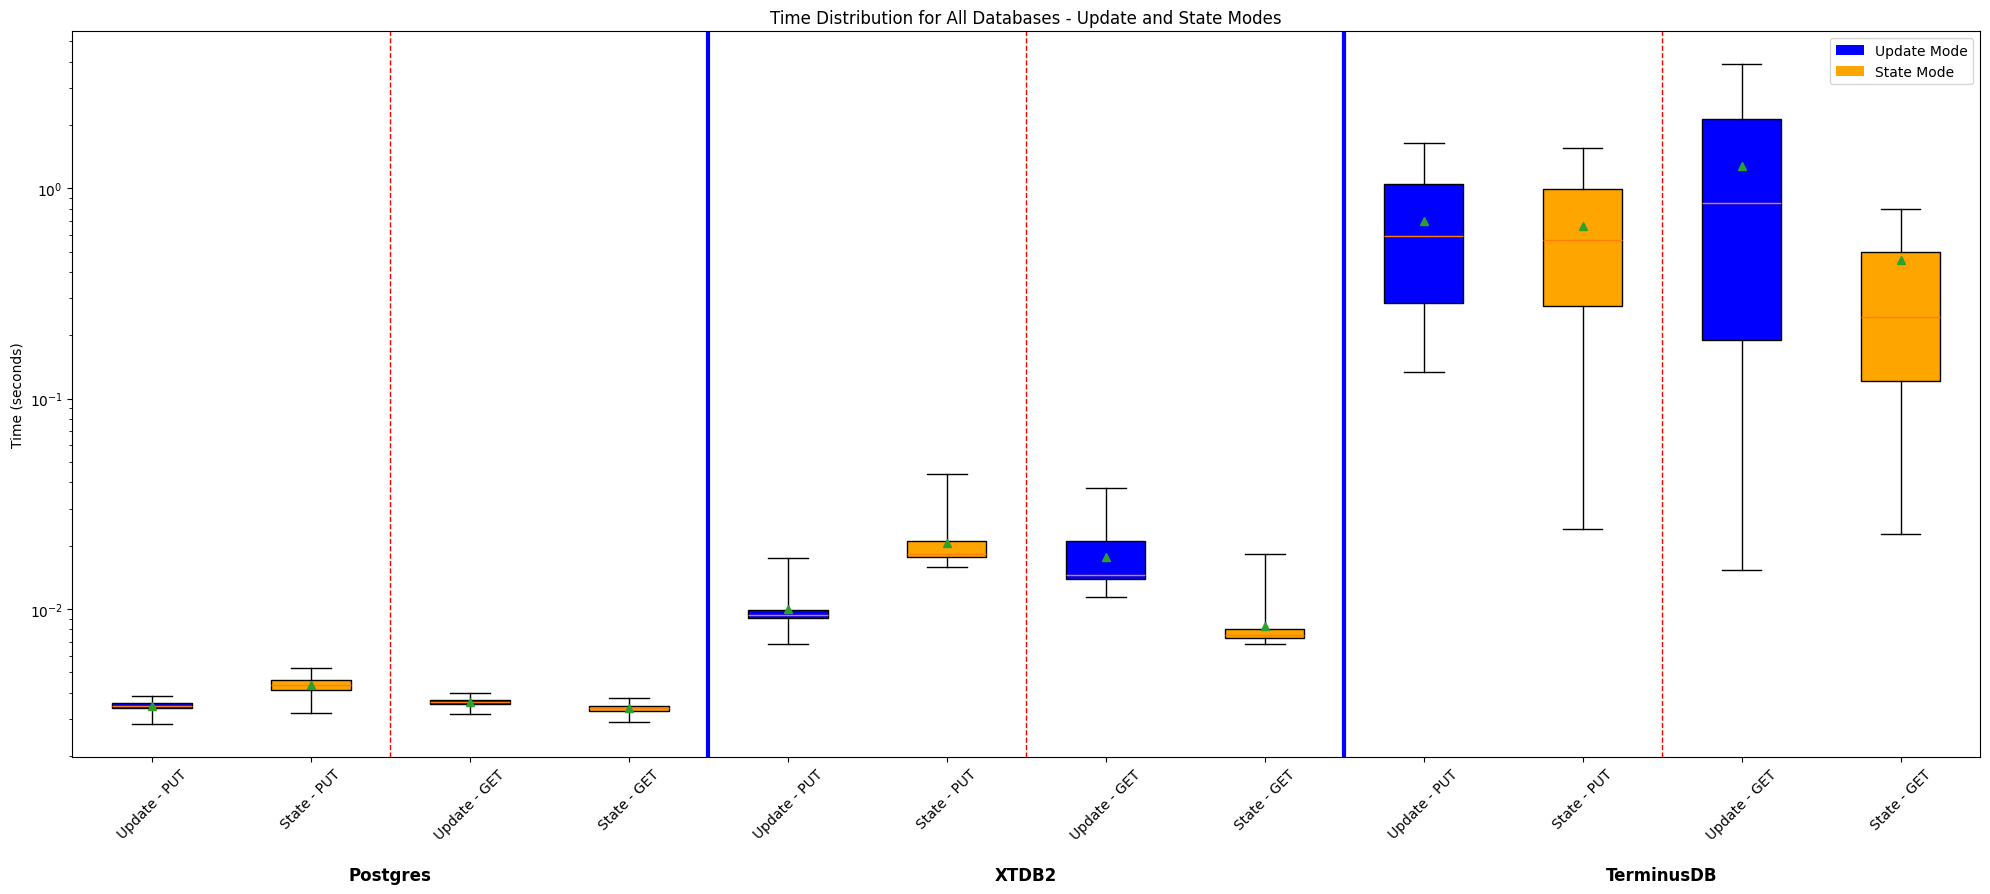

In [ ]:
# Compare the times between databases
# Use boxes from the previous loop

group_names = ['Postgres', 'XTDB2', 'TerminusDB']
group_size = 4  # Number of boxes per DB
group_positions = [group_size * i + group_size / 2 + 0.5 for i in range(len(group_names))]

fig, ax = plt.subplots(figsize=(20, 9))
bplots = ax.bxp(boxes_all, vert=True, patch_artist=True, showfliers=False, showmeans=True)
ax.set_ylabel('Time (seconds)')
ax.set_title('Time Distribution for All Databases - Update and State Modes')
ax.axvline(x=2.5, color='red', linestyle='--', linewidth=1)
ax.axvline(x=4.5, color='blue', linewidth=3)
ax.axvline(x=6.5, color='red', linestyle='--', linewidth=1)
ax.axvline(x=8.5, color='blue', linewidth=3)
ax.axvline(x=10.5, color='red', linestyle='--', linewidth=1)
#make y axis logarithmic
ax.set_yscale('log')
legend_elements = [
    Patch(facecolor='blue', label='Update Mode'),
    Patch(facecolor='orange', label='State Mode')
]
ax.legend(handles=legend_elements, loc='upper right')
colors = ["blue", "orange", "blue", "orange"] * (len(boxes_all) // 4)
for patch, clr in zip(bplots["boxes"], colors):
    patch.set_facecolor(clr)

y_offset = -0.15  # Lower this to move group names down
for pos, label in zip(group_positions, group_names):
    ax.text(pos, y_offset, label, ha='center', va='top',
            fontsize=12, fontweight='bold', transform=ax.get_xaxis_transform())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3.1   Compare the same database for all modes

In [ ]:
# Generate a summary table for the latest data

# Every database has a row.
# The columns are: Database, (Mode X Users X Rate), PUT Count, Put Time (avg), Get Time (avg)

def generate_summary_table():
    summary_data = []

    for database in ALL_DATABASES:
        for rate, users in product(RATE, USERS):
            try:
                # Construct paths for diff and state modes
                diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
                state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

                # Load the data
                diff_times = load_time_data(diff_path)
                state_times = load_time_data(state_path)

                # Filter for the latest timestamp
                latest_diff = get_latest_data(diff_times)
                latest_state = get_latest_data(state_times)
            except FileNotFoundError:
                print(f"Data not found for {database} with rate {rate} and users {users}. Skipping...")
                continue

            diff_put_times = latest_diff[latest_diff['label'] == 'ALL PUT']
            diff_get_times = latest_diff[latest_diff['label'] == 'ALL GET']
            state_put_times = latest_state[latest_state['label'] == 'ALL PUT']
            state_get_times = latest_state[latest_state['label'] == 'ALL GET']

            if not diff_put_times.empty and not state_put_times.empty:
                put_count_update = diff_put_times['count'].values[0]
                put_count_state = state_put_times['count'].values[0]
                put_avg_diff = diff_put_times['avg'].values[0]
                get_avg_diff = diff_get_times['avg'].values[0]
                put_avg_state = state_put_times['avg'].values[0]
                get_avg_state = state_get_times['avg'].values[0]

                summary_data.append([
                    database,
                    f"R-{rate}, U-{users}",
                    put_count_update,
                    put_avg_diff,
                    get_avg_diff,
                    put_count_state,
                    put_avg_state,
                    get_avg_state
                ])

    columns = [
        "Database",
        "Rate X Users",
        "PUT Count Update",
        "Update PUT Time (avg)",
        "Update GET Time (avg)",
        "Put Count State",
        "State PUT Time (avg)",
        "State GET Time (avg)"
    ]

    summary_df = pd.DataFrame(summary_data, columns=columns)
    return summary_df

summary_df = generate_summary_table()

# Display the summary table in latex format
print(summary_df.to_latex(index=False, float_format="%.4f", escape=False, column_format='lcccccc'))

Data not found for terminus with rate 1 and users 10. Skipping...
Data not found for terminus with rate 10 and users 1. Skipping...
Data not found for terminus with rate 10 and users 10. Skipping...
\begin{tabular}{lcccccc}
\toprule
Database & Rate X Users & PUT Count Update & Update PUT Time (avg) & Update GET Time (avg) & Put Count State & State PUT Time (avg) & State GET Time (avg) \\
\midrule
postgres & R-1, U-1 & 5028 & 0.0035 & 0.0036 & 5080 & 0.0044 & 0.0034 \\
postgres & R-1, U-10 & 50485 & 0.0082 & 0.0085 & 50547 & 0.0119 & 0.0054 \\
postgres & R-10, U-1 & 50615 & 0.0035 & 0.0036 & 50226 & 0.0043 & 0.0033 \\
postgres & R-10, U-10 & 503592 & 0.0050 & 0.0052 & 503196 & 0.0064 & 0.0037 \\
xtdb2 & R-1, U-1 & 4985 & 0.0100 & 0.0176 & 5143 & 0.0207 & 0.0083 \\
xtdb2 & R-1, U-10 & 50354 & 0.1050 & 0.1555 & 50276 & 0.1115 & 0.0251 \\
xtdb2 & R-10, U-1 & 50177 & 0.0092 & 0.0645 & 50185 & 0.0207 & 0.0082 \\
xtdb2 & R-10, U-10 & 153152 & 0.2921 & 0.3823 & 207642 & 0.2969 & 0.0842 \\
term

# 4. Updates and Gets from Current vs Timestamp

Processing database: postgres


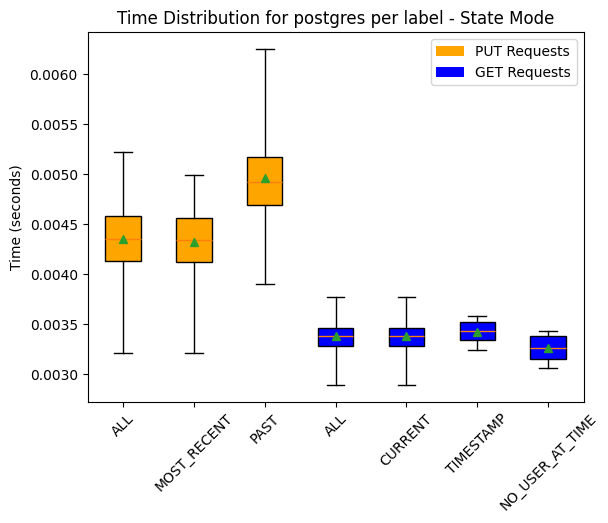

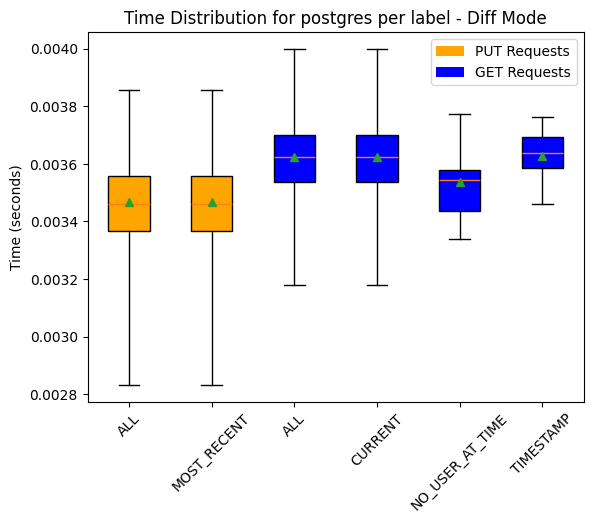

Processing database: xtdb2


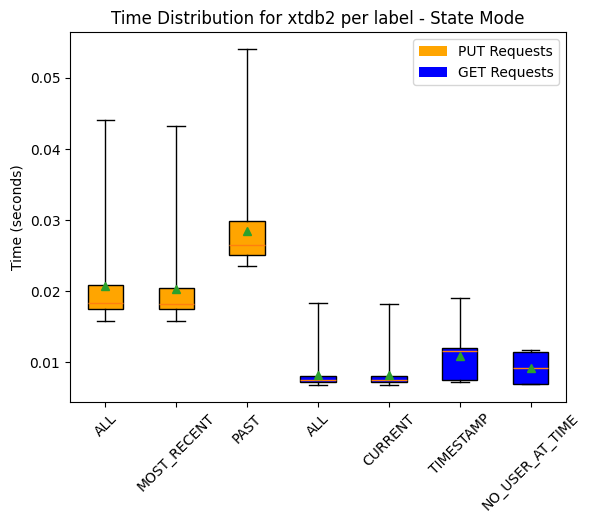

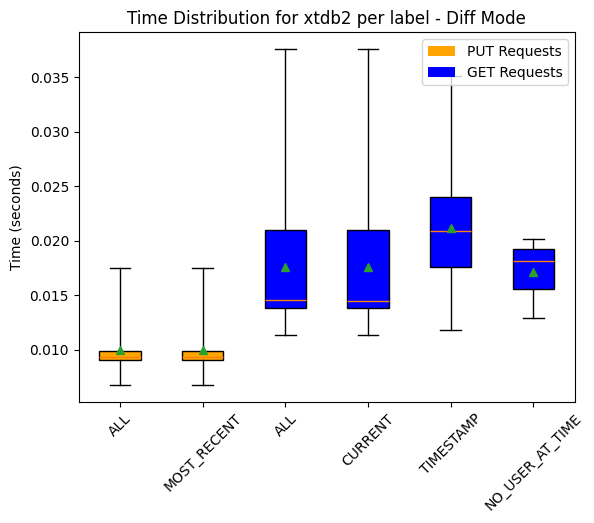

Processing database: terminus


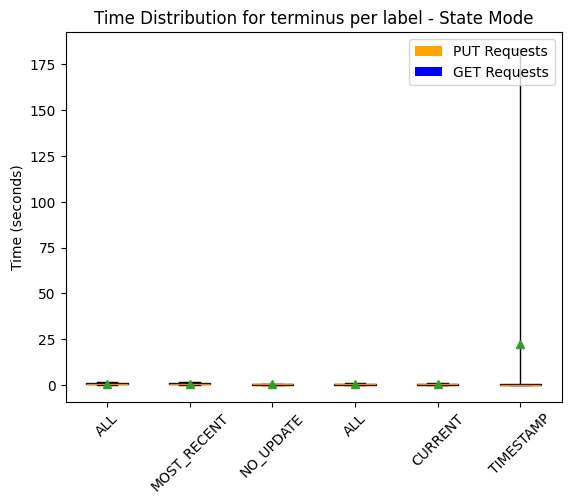

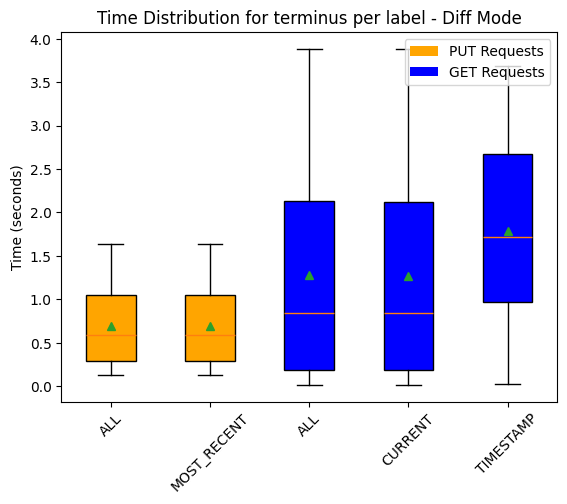

In [ ]:
#From all the csv, get only the times correspondent to the latest timestamp
#Do an boxplot of the time distribution for each label (PUT, GET, etc.), use the median, 25 and 75 percentiles
#On the x-axis, put the label (PUT, GET, etc.)
#On the y-axis, put the time in seconds

users = 1
rate = 1

boxes_all = []

rename_map = {
    'ALL PUT': 'ALL',
    'ALL GET': 'ALL',
    'PutType.MOST_RECENT': 'MOST_RECENT',
    'PutType.PAST': 'PAST',
    'PutType.NO_UPDATE': 'NO_UPDATE',
    'GetType.CURRENT': 'CURRENT',
    'GetType.TIMESTAMP': 'TIMESTAMP',
    'GetType.PAST': 'PAST',
    'GetType.NO_USER_AT_TIME': 'NO_USER_AT_TIME',
}


for database in ALL_DATABASES:
    print(f"Processing database: {database}")

    # Construct paths for diff and state modes
    diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
    state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

    # Load CSVs
    diff_times = load_time_data(diff_path)
    state_times = load_time_data(state_path)

    # Filter for the latest timestamp
    state_filtered = get_latest_data(state_times)
    diff_filtered = get_latest_data(diff_times)

    fig, ax = plt.subplots()
    
    #Take the data for ALL PUT and ALL GET and build the boxes
    colors = []
    boxes = []

    for row in state_filtered.itertuples():
        if "get" in row.label.lower():
            colors.append("blue")
        else:
            colors.append("orange")
        label = rename_map.get(row.label, row.label)
        bottom = row.min
        q1 = row.p25
        med = row.p50
        mean = row.avg
        q3 = row.p75
        top = row.p99
        boxes.append(make_box(f"{label}", bottom, q1, med, mean, q3, top))

    #Make the graph for state
    bplots = ax.bxp(boxes, vert=True, patch_artist=True, showfliers=False, showmeans=True)
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Time Distribution for {database} per label - State Mode')
    plt.xticks(rotation=45)
    legend_elements = [
        Patch(facecolor='orange', label='PUT Requests'),
        Patch(facecolor='blue', label='GET Requests')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    for patch, clr in zip(bplots["boxes"], colors):
        patch.set_facecolor(clr)
    #plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots()
    
    #Take the data for ALL PUT and ALL GET and build the boxes
    colors = []
    boxes = []

    for row in diff_filtered.itertuples():
        if "get" in row.label.lower():
            colors.append("blue")
        else:
            colors.append("orange")
        label = rename_map.get(row.label, row.label)
        bottom = row.min
        q1 = row.p25
        med = row.p50
        mean = row.avg
        q3 = row.p75
        top = row.p99
        boxes.append(make_box(f"{label}", bottom, q1, med, mean, q3, top))

    #Make the graph for state
    bplots = ax.bxp(boxes, vert=True, patch_artist=True, showfliers=False, showmeans=True)
    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Time Distribution for {database} per label - Diff Mode')
    plt.xticks(rotation=45)
    legend_elements = [
        Patch(facecolor='orange', label='PUT Requests'),
        Patch(facecolor='blue', label='GET Requests')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    for patch, clr in zip(bplots["boxes"], colors):
        patch.set_facecolor(clr)
    #plt.tight_layout()
    plt.show()




# 4.1 Table with average every type of requests for the 3 databases

In [48]:
users = 1
rate = 1

rename_map = {
    'ALL PUT': 'ALL PUT',
    'ALL GET': 'ALL GET',
    'PutType.MOST_RECENT': 'PUT - MOST_RECENT',
    'PutType.PAST': 'PUT - PAST',
    'PutType.NO_UPDATE': 'PUT - NO_UPDATE',
    'GetType.CURRENT': 'GET - CURRENT',
    'GetType.TIMESTAMP': 'GET - TIMESTAMP',
    'GetType.PAST': 'GET - PAST',
    'GetType.NO_USER_AT_TIME': 'GET - NO_USER_AT_TIME',
}


# Generate a summary table for the latest data

# Every database has a row.
# The columns are: Database, (Mode X Users X Rate), PUT Count, Put Time (avg), Get Time (avg)

def generate_summary_per_type_table():
    summary_df = pd.DataFrame()

    for database in ALL_DATABASES:
        try:
            # Construct paths for diff and state modes
            diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
            state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

            # Load the data
            diff_times = load_time_data(diff_path)
            state_times = load_time_data(state_path)

            # Filter for the latest timestamp
            latest_diff = get_latest_data(diff_times)
            latest_state = get_latest_data(state_times)
        except FileNotFoundError:
            print(f"Data not found for {database} with rate {rate} and users {users}. Skipping...")
            continue

        #For every row on the diff and state data, get the label, avg time and 99th percentile
        diff_times = latest_diff[['label', 'avg', 'p99']].copy()
        state_times = latest_state[['label', 'avg', 'p99']].copy()
        diff_times['label'] = diff_times['label'].map(rename_map)
        state_times['label'] = state_times['label'].map(rename_map)


        display(diff_times)
        display(state_times)

        #Append diff_times and state_times to the summary_df, each in a new row
        diff_times['Database'] = database
        state_times['Database'] = database
        diff_times['Mode'] = 'Update'
        state_times['Mode'] = 'State'
        
        diff_times = diff_times.rename(columns={'avg': 'Avg Time', 'p99': '99th Percentile'})
        state_times = state_times.rename(columns={'avg': 'Avg Time', 'p99': '99th Percentile'})
        diff_times = diff_times[['Database', 'Mode', 'label', 'Avg Time', '99th Percentile']]
        state_times = state_times[['Database', 'Mode', 'label', 'Avg Time', '99th Percentile']]
        summary_df = pd.concat([summary_df, diff_times, state_times], ignore_index=True)

    
    return summary_df

summary_df = generate_summary_per_type_table()

display(summary_df)

# Display the summary table in latex format
#print(summary_df.to_latex(index=False, float_format="%.4f", escape=False, column_format='lcccccc'))

,label,avg,p99
20,ALL PUT,0.003466,0.003855
21,PUT - MOST_RECENT,0.003466,0.003855
22,ALL GET,0.003623,0.003999
23,GET - CURRENT,0.003623,0.003999
24,GET - NO_USER_AT_TIME,0.003536,0.003772
25,GET - TIMESTAMP,0.003628,0.003762


,label,avg,p99
23,ALL PUT,0.004352,0.005219
24,PUT - MOST_RECENT,0.004325,0.004994
25,PUT - PAST,0.004967,0.006253
26,ALL GET,0.003382,0.003769
27,GET - CURRENT,0.003382,0.003770
28,GET - TIMESTAMP,0.003427,0.003583
29,GET - NO_USER_AT_TIME,0.003259,0.003429


,label,avg,p99
19,ALL PUT,0.009964,0.017508
20,PUT - MOST_RECENT,0.009964,0.017508
21,ALL GET,0.017625,0.037562
22,GET - CURRENT,0.017595,0.037598
23,GET - TIMESTAMP,0.021197,0.035103
24,GET - NO_USER_AT_TIME,0.017112,0.020185


,label,avg,p99
21,ALL PUT,0.020671,0.043999
22,PUT - MOST_RECENT,0.020328,0.043174
23,PUT - PAST,0.028444,0.054056
24,ALL GET,0.008291,0.018329
25,GET - CURRENT,0.008276,0.018247
26,GET - TIMESTAMP,0.010944,0.019076
27,GET - NO_USER_AT_TIME,0.009260,0.011750


,label,avg,p99
17,ALL PUT,0.696311,1.634948
18,PUT - MOST_RECENT,0.696311,1.634948
19,ALL GET,1.278118,3.883298
20,GET - CURRENT,1.273906,3.883484
21,GET - TIMESTAMP,1.784989,3.689113


,label,avg,p99
20,ALL PUT,0.665457,1.552326
21,PUT - MOST_RECENT,0.680910,1.552521
22,PUT - NO_UPDATE,0.303794,0.747977
23,ALL GET,0.456400,0.801351
24,GET - CURRENT,0.317097,0.800699
25,GET - TIMESTAMP,22.342578,183.507002


,Database,Mode,label,Avg Time,99th Percentile
0,postgres,Update,ALL PUT,0.003466,0.003855
1,postgres,Update,PUT - MOST_RECENT,0.003466,0.003855
2,postgres,Update,ALL GET,0.003623,0.003999
3,postgres,Update,GET - CURRENT,0.003623,0.003999
4,postgres,Update,GET - NO_USER_AT_TIME,0.003536,0.003772
5,postgres,Update,GET - TIMESTAMP,0.003628,0.003762
6,postgres,State,ALL PUT,0.004352,0.005219
7,postgres,State,PUT - MOST_RECENT,0.004325,0.004994
8,postgres,State,PUT - PAST,0.004967,0.006253
9,postgres,State,ALL GET,0.003382,0.003769


# 5. Increasing the Rate

Check if the database can keep with the expected troughput when the client number of rate of requests is increased

Processing database: postgres
Processing users: 1, rate: 1
Processing users: 1, rate: 10
Processing users: 10, rate: 1
Processing users: 10, rate: 10
Processing database: xtdb2
Processing users: 1, rate: 1
Processing users: 1, rate: 10
Processing users: 10, rate: 1
Processing users: 10, rate: 10
Processing database: terminus
Processing users: 1, rate: 1
Processing users: 1, rate: 10
Error processing users: 1, rate: 10 for database terminus: [Errno 2] No such file or directory: 'output-aws/terminus/state/time-120-users-1-gpt-30-now-99-rate-10/times.csv'
Processing users: 10, rate: 1
Error processing users: 10, rate: 1 for database terminus: [Errno 2] No such file or directory: 'output-aws/terminus/diff/time-120-users-10-gpt-30-now-99-rate-1/times.csv'
Processing users: 10, rate: 10
Error processing users: 10, rate: 10 for database terminus: [Errno 2] No such file or directory: 'output-aws/terminus/diff/time-120-users-10-gpt-30-now-99-rate-10/times.csv'


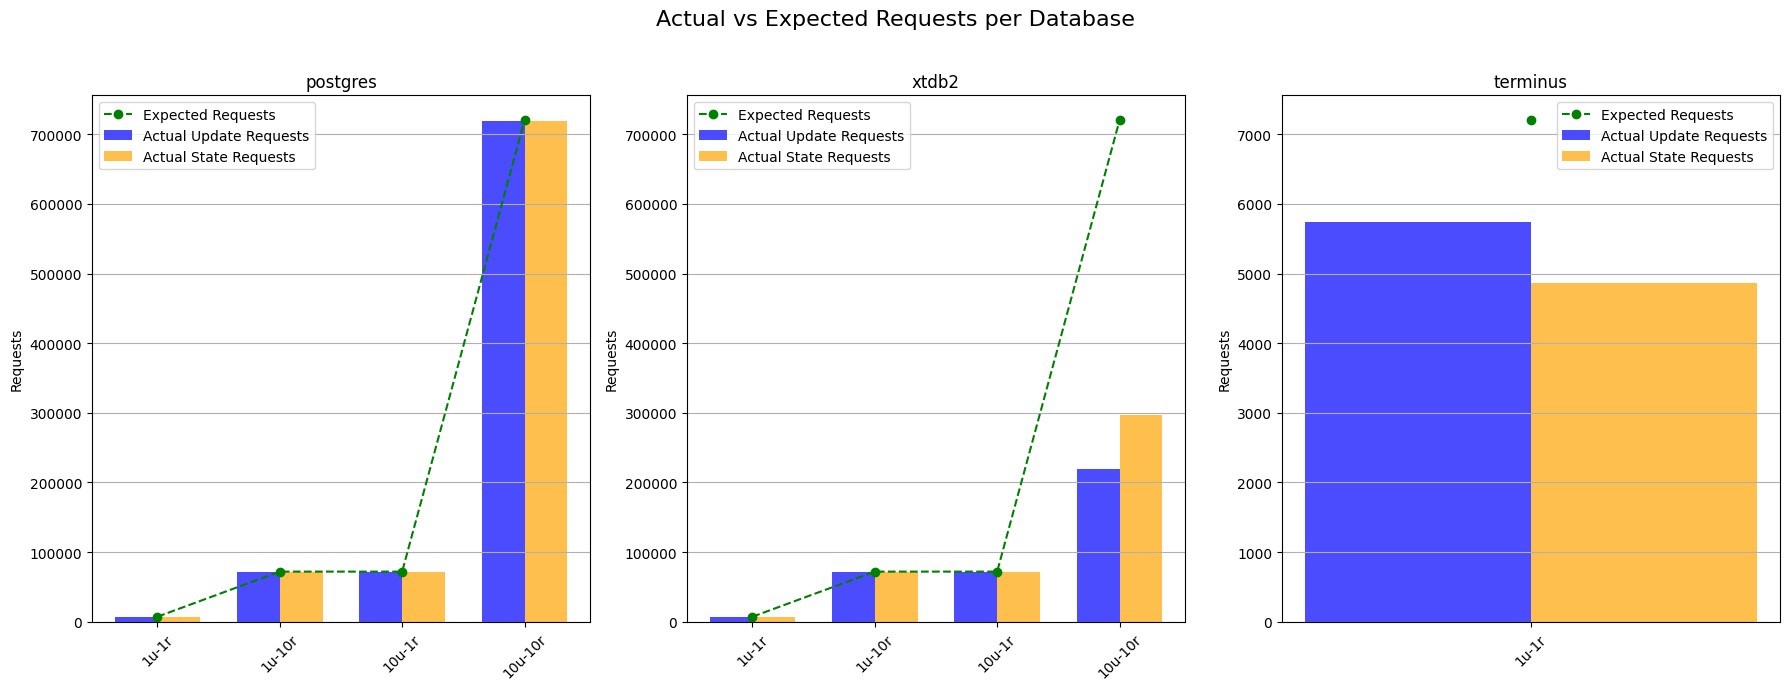

In [26]:
#Make a barplot for all databases, with the actual number of requests in the last minute (PUT + GET). Add a control line with the expected number of requests (users * rate * time)

import matplotlib.pyplot as plt
import math

boxes_all = []

# Calculate subplot grid dimensions
n_databases = len(ALL_DATABASES)
cols = 3  # or any other number you prefer
rows = math.ceil(n_databases / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 6, rows * 7), squeeze=False)
fig.suptitle("Actual vs Expected Requests per Database", fontsize=16)

for idx, database in enumerate(ALL_DATABASES):
    print(f"Processing database: {database}")

    labels = []
    actual_requests = []
    expected_requests = []

    for users in USERS:
        for rate in RATE:
            try:
                print(f"Processing users: {users}, rate: {rate}")

                diff_path = make_path(database, "diff", TIME, GPT, NOW, users, rate)
                state_path = make_path(database, "state", TIME, GPT, NOW, users, rate)

                diff_times = load_time_data(diff_path)
                state_times = load_time_data(state_path)

                diff_filtered = get_latest_data(diff_times)
                state_filtered = get_latest_data(state_times)

                diff_put = diff_filtered[diff_filtered['label'] == 'ALL PUT']['count'].values[0]
                diff_get = diff_filtered[diff_filtered['label'] == 'ALL GET']['count'].values[0]
                state_put = state_filtered[state_filtered['label'] == 'ALL PUT']['count'].values[0]
                state_get = state_filtered[state_filtered['label'] == 'ALL GET']['count'].values[0]

                total_diff = diff_put + diff_get
                total_state = state_put + state_get
                expected = users * rate * TIME * 60

                labels.append((f"{users}u-{rate}r"))
                actual_requests.append((total_diff, total_state))
                expected_requests.append((expected, expected))
            except Exception as e:
                print(f"Error processing users: {users}, rate: {rate} for database {database}: {e}")
                continue

    # Plotting per-database subplot
    row, col = divmod(idx, cols)
    ax = axs[row][col]
    bar_width = 0.35
    x = range(len(labels))
    bar1_x = [i for i in x]
    bar2_x = [i + bar_width for i in x]
    midpoints = [i + bar_width / 2 for i in x]

    ax.bar(bar1_x, [req[0] for req in actual_requests], width=bar_width, label='Actual Update Requests', color='blue', alpha=0.7)
    ax.bar(bar2_x, [req[1] for req in actual_requests], width=bar_width, label='Actual State Requests', color='orange', alpha=0.7)
    ax.plot(midpoints, [req[0] for req in expected_requests], label='Expected Requests', color='green', linestyle='--', marker='o')

    ax.set_xticks(midpoints)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylabel('Requests')
    ax.set_title(f'{database}')
    ax.grid(axis='y')
    ax.legend()

# Hide any unused subplots
for i in range(n_databases, rows * cols):
    fig.delaxes(axs[i // cols][i % cols])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


    

# 6. How the HISTORY endpoint gets slower with time

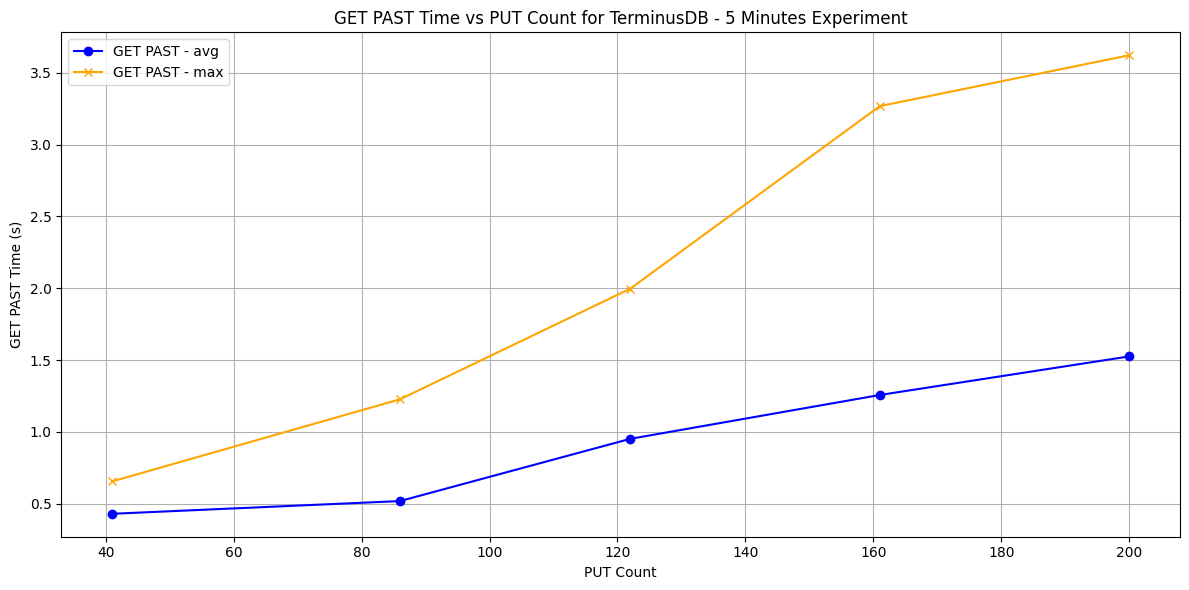

In [50]:
path_name = "output-aws/terminus/state/time-5-users-1-gpt-30-now-10-rate-1"

terminus_example = load_time_data_indexed(path_name)

#display(terminus_example)

# Check the evolution of the GET.PAST over time / over PUT count
plt.figure(figsize=(12, 6))
plt.plot(terminus_example['count']['ALL PUT'], terminus_example['avg']['GetType.PAST'], label='GET PAST - avg', color='blue', marker='o')
plt.plot(terminus_example['count']['ALL PUT'], terminus_example['max']['GetType.PAST'], label='GET PAST - max', color='orange', marker='x')
plt.xlabel('PUT Count')
plt.ylabel('GET PAST Time (s)')
plt.title('GET PAST Time vs PUT Count for TerminusDB - 5 Minutes Experiment')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()